# [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)

This notebook shows diferent basic steps for classifying disaster tweets.

## NLP:
---

* [Tf-idf (term frequency–inverse document frequency)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
* [Fasttext](https://fasttext.cc/)
* [Shallow network](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

## Table of contents
---

1. Import libraries
2. Import datasets
3. Data cleaning and processing
4. Basic EDA
 
 4.1 Clustering
 
5. Fasttext Supervised
6. Tf-idf & TruncatedSVD
7. Shallow neural network (pytorch)

## Import libraries
---

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
import fasttext
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import gc
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import ngrams_iterator
from torch.utils.data import DataLoader
import time
from torch.utils.data.dataset import random_split
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import torchtext
from torchtext import data
import spacy
import pandas_profiling as pp
from collections import Counter
from itertools import chain
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

## Import datasets
----

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [3]:
temp_3 = train_df
test_temp = test_df

## Data cleaning and pre-processing
-------

* Removing punctuation, special characters, emojis, numbers, links
* Lower letters only and split them
* Removing stopwords 
> "Words such as “the”, “will”, and “you” — called stopwords — appear the most in a corpus of text, but are of very little significance. Instead, the words which are rare are the ones that actually help in distinguishing between the data, and carry more weight."

In [4]:
def review_to_words( raw_review ):
    
    review_text = BeautifulSoup(raw_review).get_text() 
    
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    words = letters_only.lower().split()                             
 
    stops = set(stopwords.words("english"))                  

    meaningful_words = [w for w in words if not w in stops]   

    return( " ".join( meaningful_words )) 

## EDA
------

In [5]:
temp_3['is_train'] = True
test_temp['is_train'] = False

df = pd.concat([temp_3, test_temp], sort=False, ignore_index=True).set_index('id').sort_index()

#### Class distribution

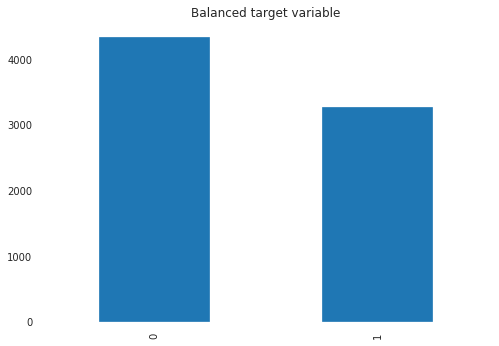

In [6]:
temp_3.target.value_counts().plot.bar(title="Balanced target variable")

In [7]:
disaster = temp_3.loc[temp_3.target == 1]
nondisaster = temp_3.loc[temp_3.target == 0]

disaster['text'] = disaster["text"].apply(review_to_words) 
nondisaster['text'] = nondisaster["text"].apply(review_to_words) 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



* 20 Most common words related to disaster tweets

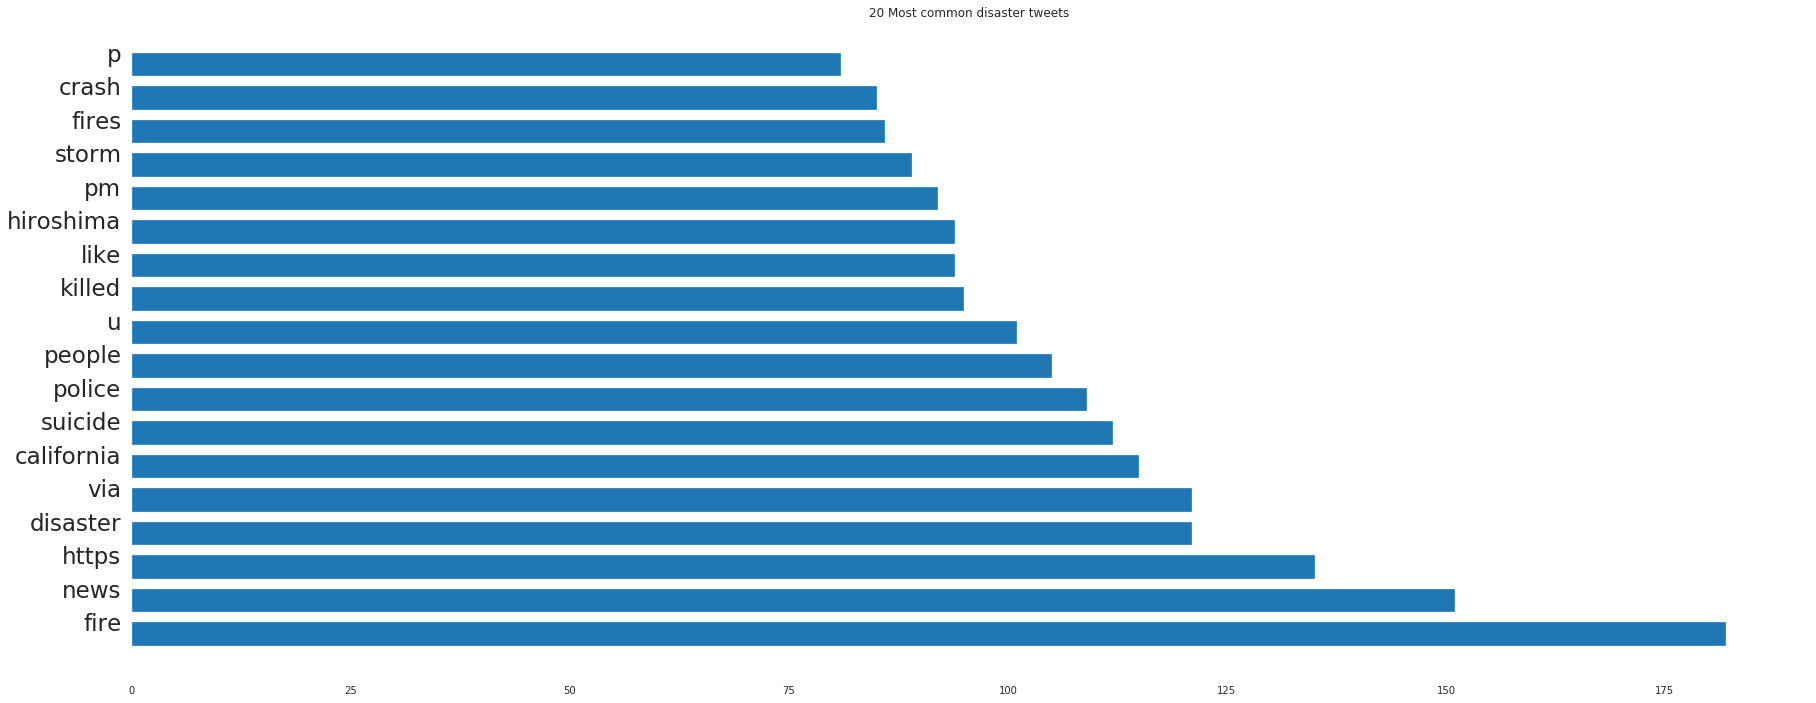

In [8]:
labels, values = zip(*Counter(" ".join(disaster["text"]).split()).most_common(20)[2:])

indexes = np.arange(len(labels))
width = 0.7

plt.figure(figsize=(30,12))
plt.barh(indexes, values, width)
plt.yticks(indexes + width * 0.5, labels)
plt.yticks(fontsize=23)
plt.title('20 Most common disaster tweets')
plt.show()

* 20 Most common words related to nondisaster tweets

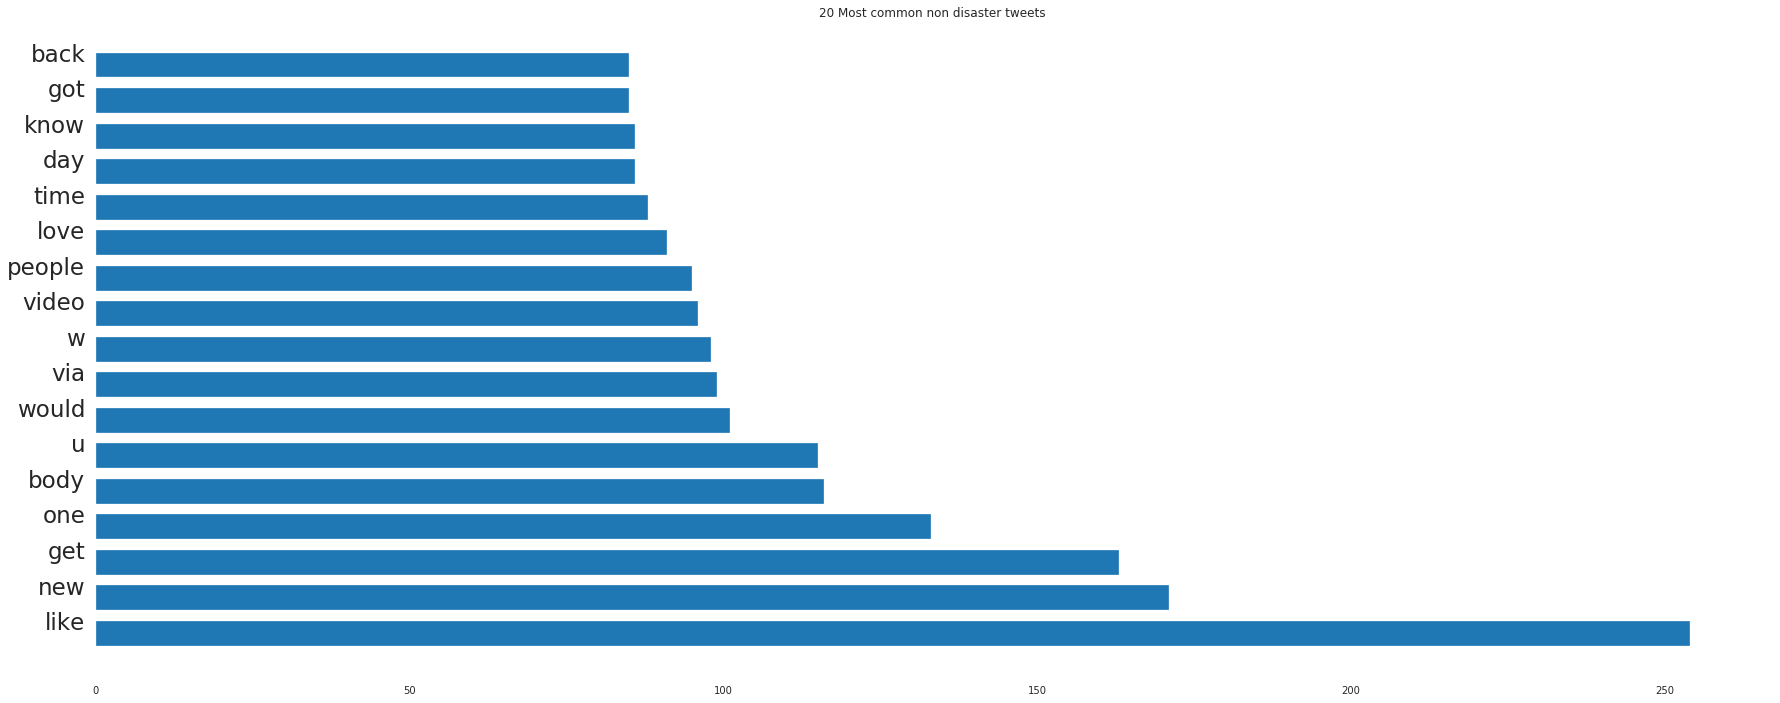

In [9]:
labels, values = zip(*Counter(" ".join(nondisaster["text"]).split()).most_common(20)[3:])

indexes = np.arange(len(labels))
width = 0.7

plt.figure(figsize=(30,12))
plt.barh(indexes, values, width, )
plt.yticks(indexes + width * 0.5, labels)
plt.yticks(fontsize=23)
plt.title('20 Most common non disaster tweets')
plt.show()

* 20 Most common locations of disaster tweets

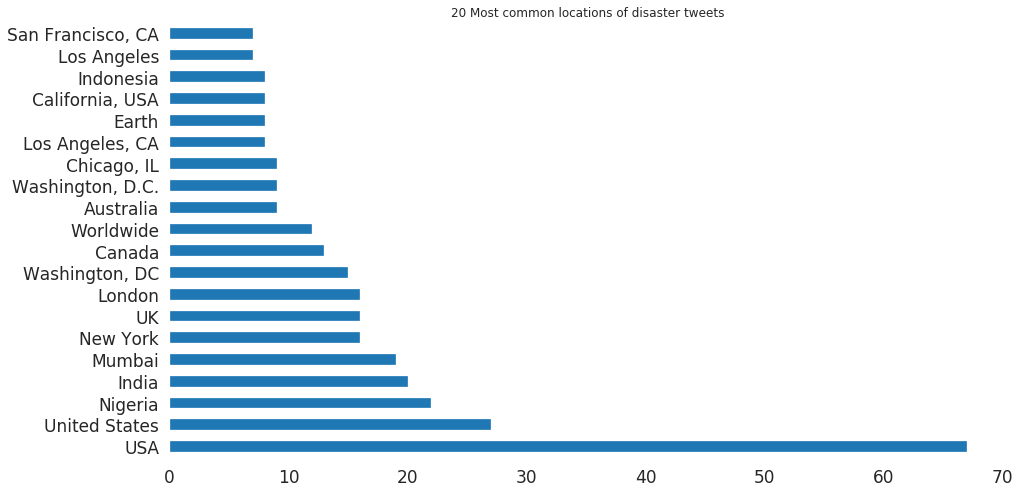

In [10]:
disaster["location"].dropna().value_counts()[:20].plot.barh(figsize=(15, 8), title="20 Most common locations of disaster tweets", fontsize=17)

* 20 Most common locations of nondisaster tweets

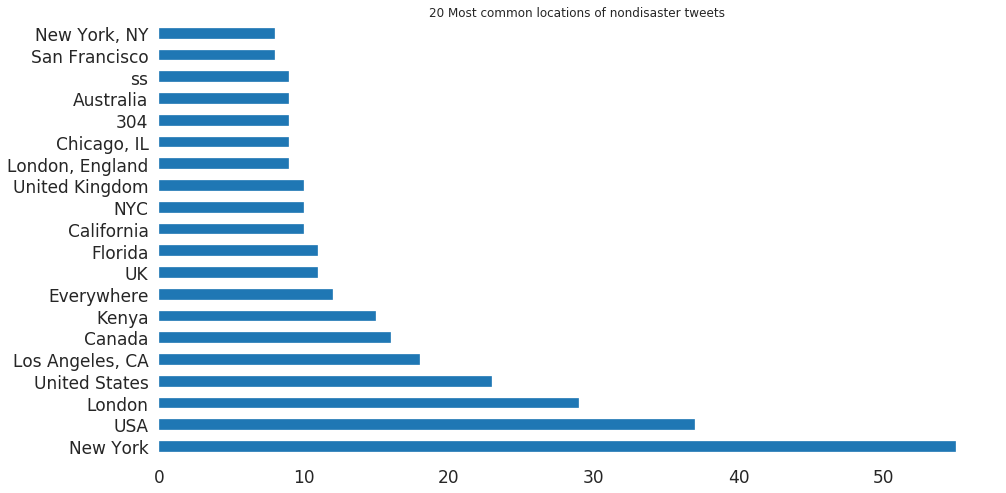

In [11]:
nondisaster["location"].dropna().value_counts()[:20].plot.barh(figsize=(15, 8), title="20 Most common locations of nondisaster tweets", fontsize=17)

* 20 Most common keywords of disaster tweets

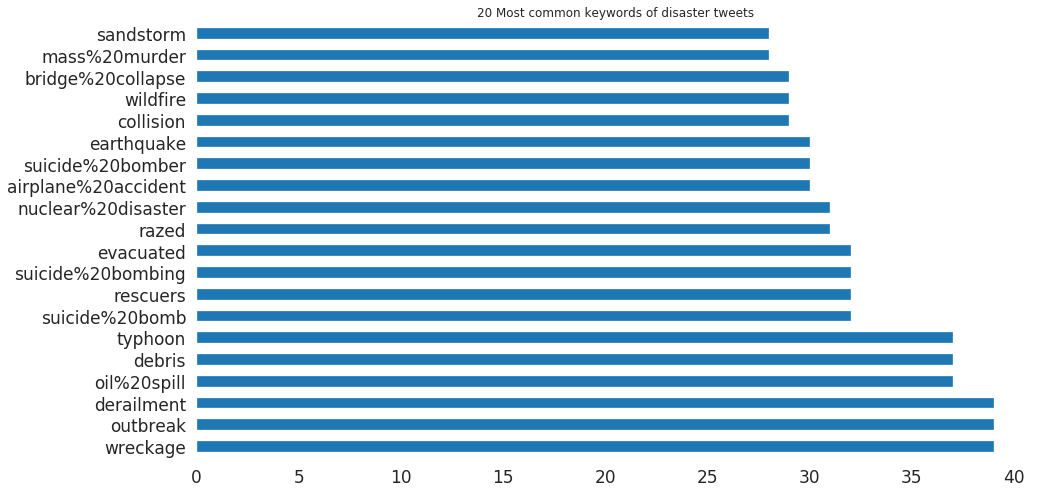

In [12]:
disaster['keyword'].dropna().value_counts()[:20].plot.barh(figsize=(15, 8), title="20 Most common keywords of disaster tweets", fontsize=17)

* 20 Most common keywords of nondisaster tweets

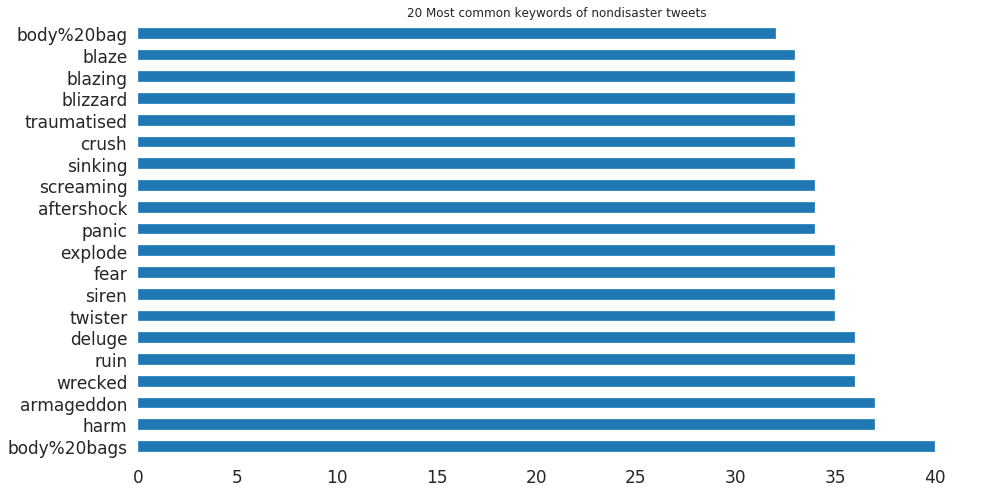

In [13]:
nondisaster['keyword'].dropna().value_counts()[:20].plot.barh(figsize=(15, 8), title="20 Most common keywords of nondisaster tweets", fontsize=17)

* N-grams visualization

In [14]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



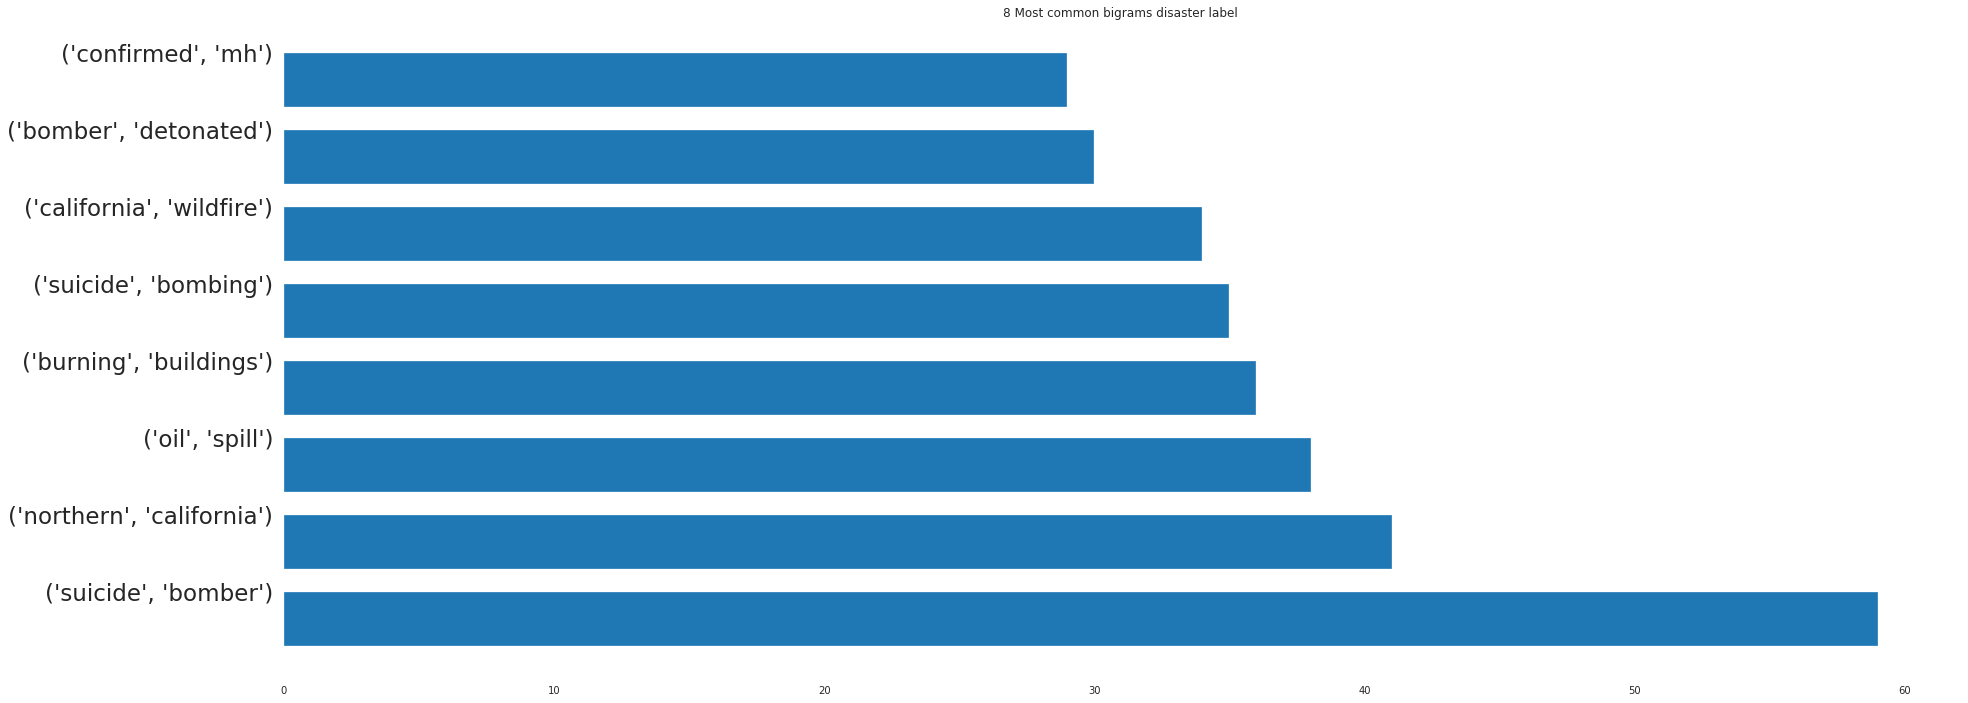

In [15]:
disaster['bigrams'] = disaster['text'].map(lambda x: find_ngrams(x.split(" "), 2))

bigrams = disaster['bigrams'].tolist()
bigrams = list(chain(*bigrams))
bigrams = [(x.lower(), y.lower()) for x,y in bigrams]

labels, values = zip(*Counter(bigrams).most_common(10)[2:])

indexes = np.arange(len(labels))
width = 0.7

plt.figure(figsize=(30,12))
plt.barh(indexes, values, width, )
plt.yticks(indexes + width * 0.5, labels)
plt.yticks(fontsize=23)
plt.title('8 Most common bigrams disaster label')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



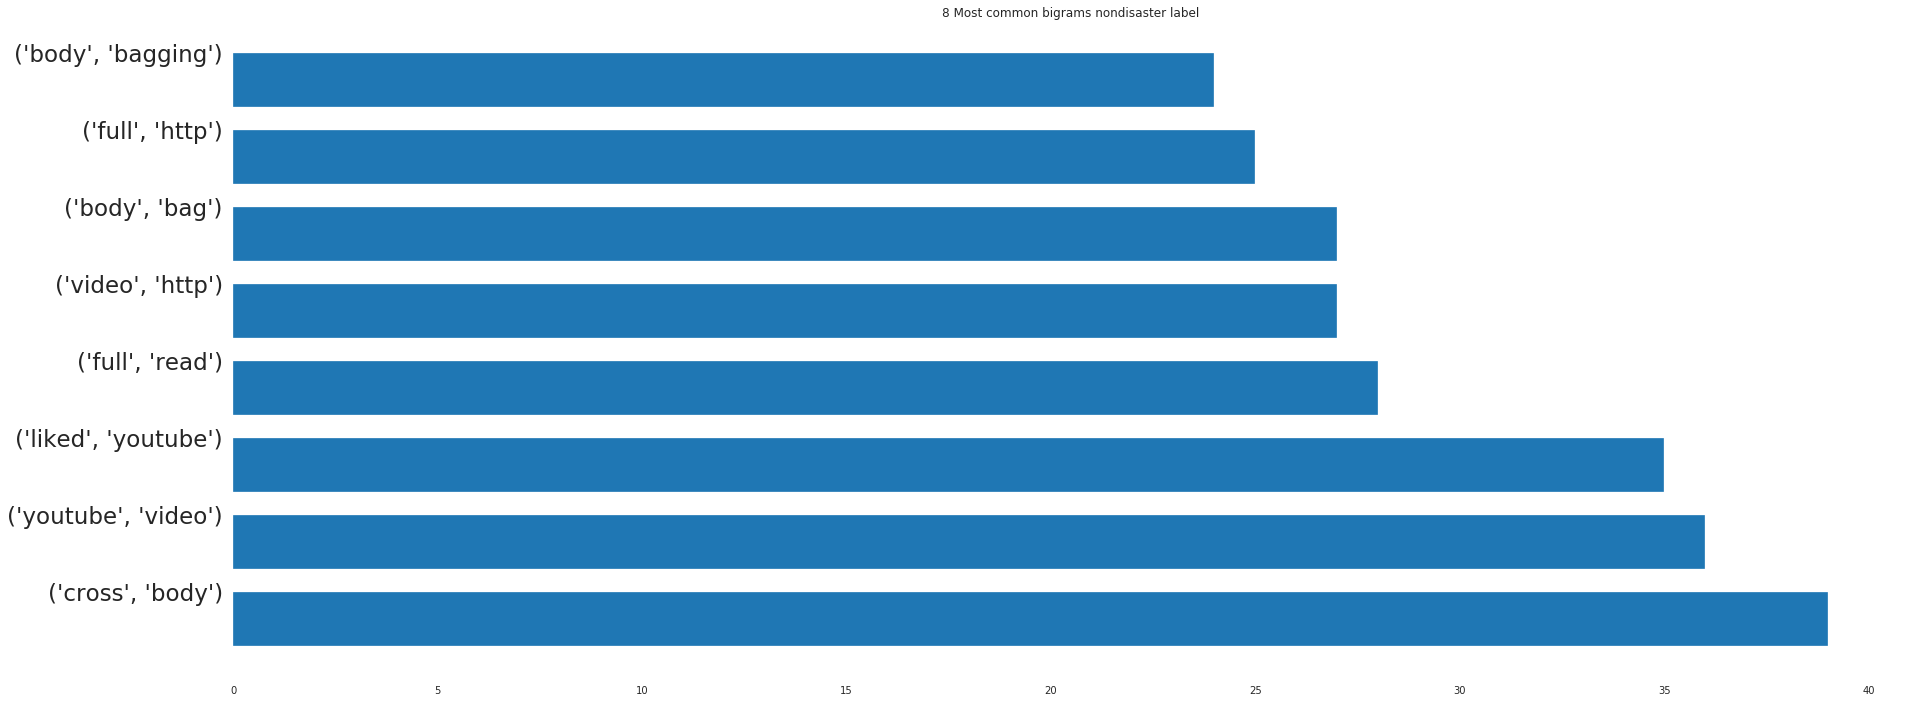

In [16]:
nondisaster['bigrams'] = nondisaster['text'].map(lambda x: find_ngrams(x.split(" "), 2))

bigrams = nondisaster['bigrams'].tolist()
bigrams = list(chain(*bigrams))
bigrams = [(x.lower(), y.lower()) for x,y in bigrams]

labels, values = zip(*Counter(bigrams).most_common(10)[2:])

indexes = np.arange(len(labels))
width = 0.7

plt.figure(figsize=(30,12))
plt.barh(indexes, values, width, )
plt.yticks(indexes + width * 0.5, labels)
plt.yticks(fontsize=23)
plt.title('8 Most common bigrams nondisaster label')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



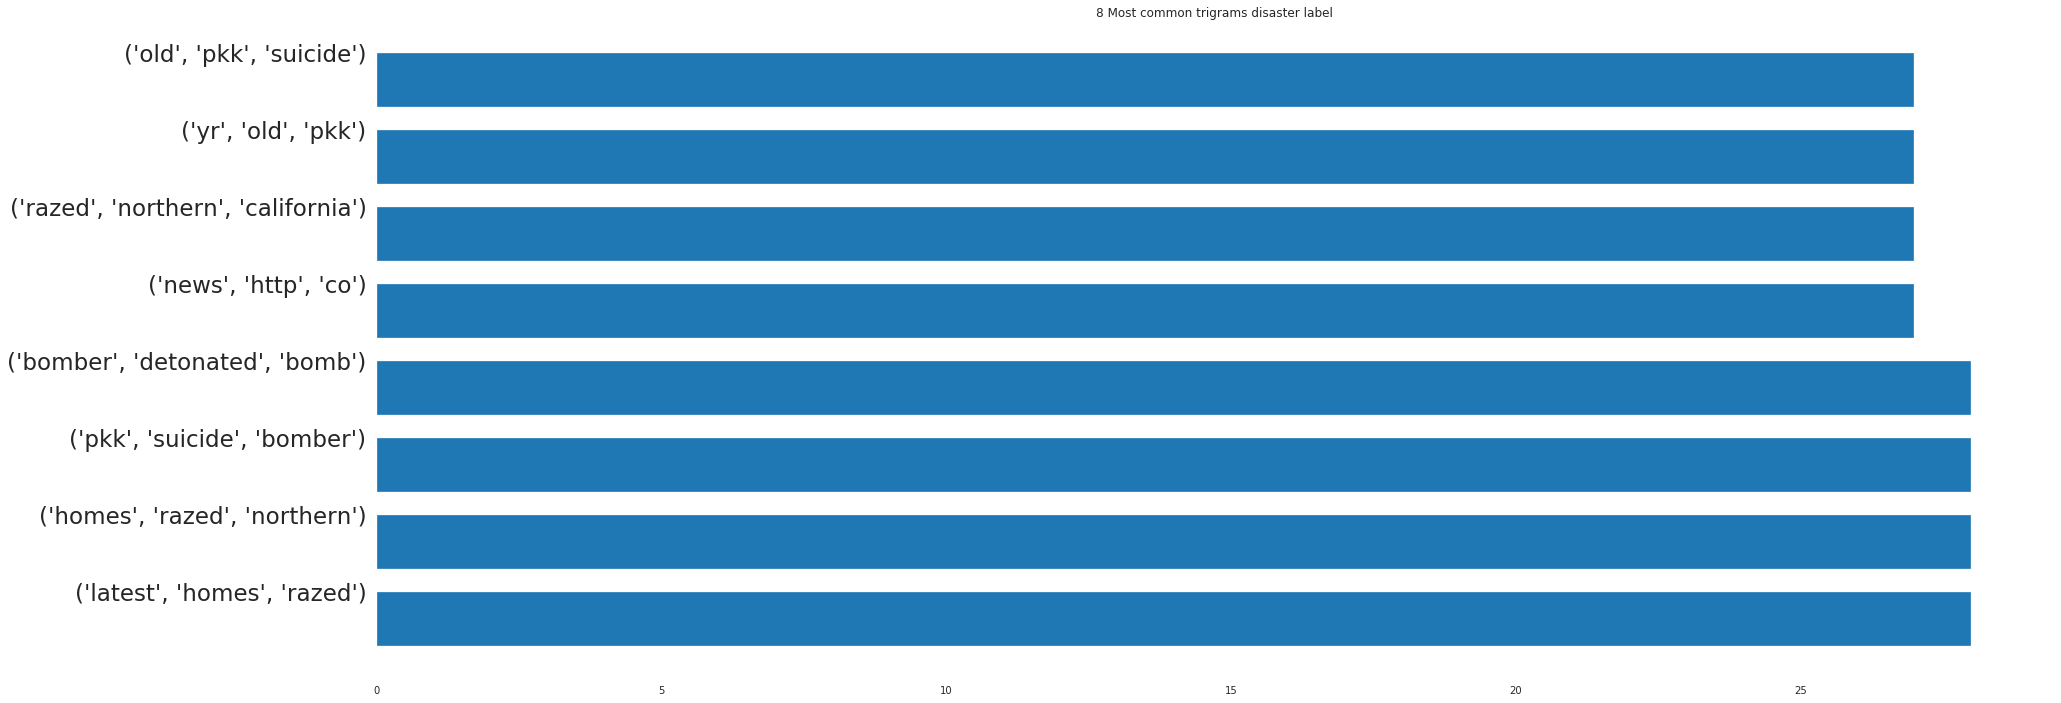

In [17]:
disaster['trigrams'] = disaster['text'].map(lambda x: find_ngrams(x.split(" "), 3))

trigrams = disaster['trigrams'].tolist()
trigrams = list(chain(*trigrams))
trigrams = [(x.lower(), y.lower(), z.lower()) for x,y,z in trigrams]

labels, values = zip(*Counter(trigrams).most_common(10)[2:])

indexes = np.arange(len(labels))
width = 0.7

plt.figure(figsize=(30,12))
plt.barh(indexes, values, width, )
plt.yticks(indexes + width * 0.5, labels)
plt.yticks(fontsize=23)
plt.title('8 Most common trigrams disaster label')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



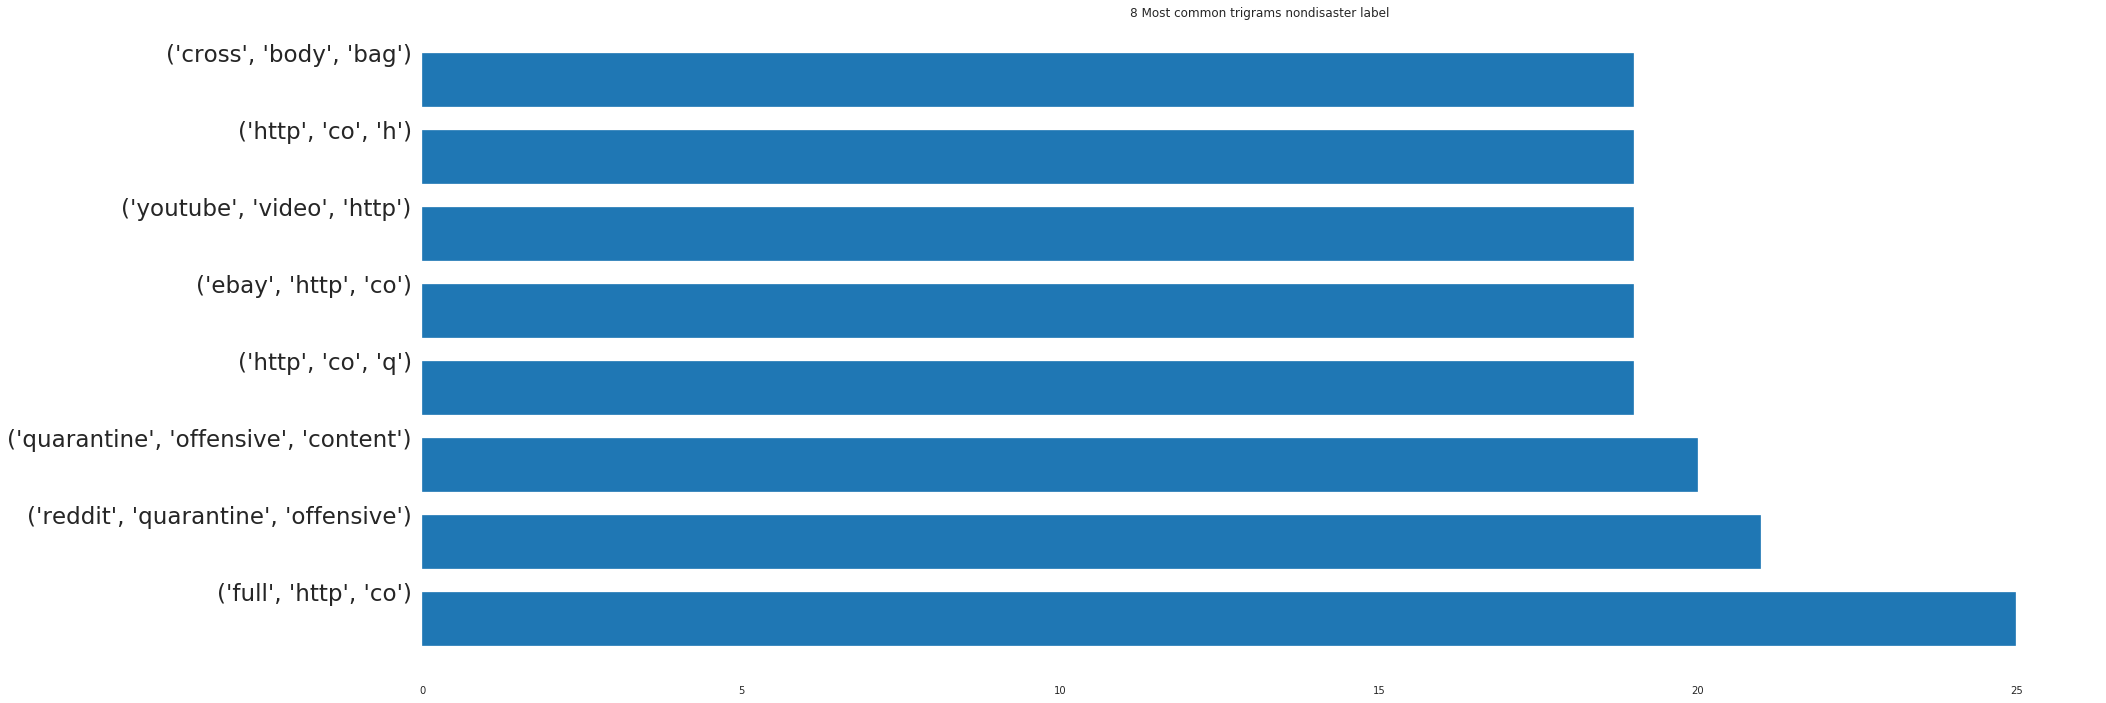

In [18]:
nondisaster['trigrams'] = nondisaster['text'].map(lambda x: find_ngrams(x.split(" "), 3))

trigrams = nondisaster['trigrams'].tolist()
trigrams = list(chain(*trigrams))
trigrams = [(x.lower(), y.lower(), z.lower()) for x,y,z in trigrams]

labels, values = zip(*Counter(trigrams).most_common(10)[2:])

indexes = np.arange(len(labels))
width = 0.7

plt.figure(figsize=(30,12))
plt.barh(indexes, values, width, )
plt.yticks(indexes + width * 0.5, labels)
plt.yticks(fontsize=23)
plt.title('8 Most common trigrams nondisaster label')
plt.show()

In [19]:
del temp_3, test_temp
gc.collect()

28133

### Clustering
----

In [20]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [21]:
train['text'] = train['text'].apply(review_to_words) 

* #### Vectorize with HashingVectorizer
* #### Dimensionality Reduction with t-SNE
* #### Clustering with K-Means

In [22]:
train['bigrams'] = train['text'].map(lambda x: find_ngrams(x.split(" "), 2))

In [23]:
dropcols = ['id', 'keyword', 'location', 'target', 'bigrams']

text = train.drop(dropcols, axis=1)
text_arr = text.stack().tolist()

In [24]:
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['text']).split(" "))

words[0][:10]

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

In [25]:
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

n_gram_all[0][:10]

['deedsreason',
 'reasonearthquake',
 'earthquakemay',
 'mayallah',
 'allahforgive',
 'forgiveus']

In [26]:
# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, ngram_range=(1,2), n_features=2**12)
#vectorizer = TfidfVectorizer(lowercase=False, analyzer=lambda l:l)

# features matrix X
X = hvec.fit_transform(n_gram_all)
#X = vectorizer.fit_transform(n_gram_all)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:516: UserWarning:

The parameter 'ngram_range' will not be used since 'analyzer' is callable'



In [27]:
X.shape

(7613, 4096)

In [28]:
X_train, X_test = train_test_split(X.toarray(), test_size=0.2, random_state=42)
#X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 6090
X_test size: 1523 



In [29]:
#tsne = TSNE(verbose=1, perplexity=10)
tsne = TSNE(verbose=1, perplexity=5)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 6090 samples in 5.417s...
[t-SNE] Computed neighbors for 6090 samples in 329.383s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6090
[t-SNE] Computed conditional probabilities for sample 2000 / 6090
[t-SNE] Computed conditional probabilities for sample 3000 / 6090
[t-SNE] Computed conditional probabilities for sample 4000 / 6090
[t-SNE] Computed conditional probabilities for sample 5000 / 6090
[t-SNE] Computed conditional probabilities for sample 6000 / 6090
[t-SNE] Computed conditional probabilities for sample 6090 / 6090
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 133.617981
[t-SNE] KL divergence after 1000 iterations: 4.630849


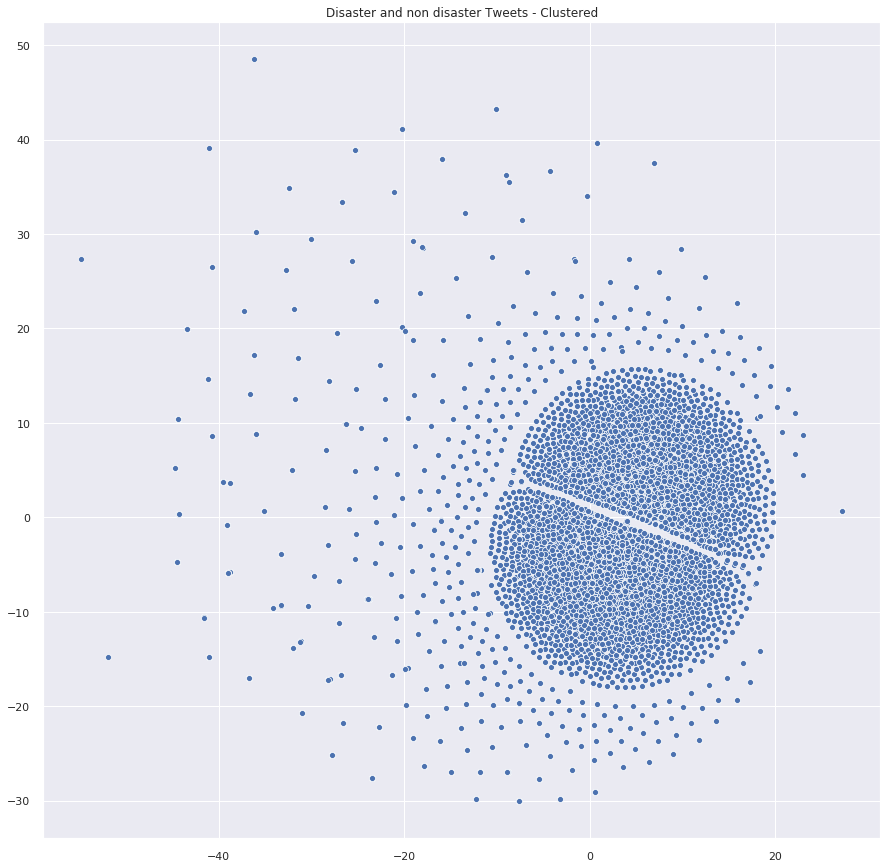

In [30]:
sns.set(rc={'figure.figsize':(15,15)})

palette = sns.color_palette("bright", 1)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("Disaster and non disaster Tweets - Clustered")
plt.show()

In [31]:
k = 2
kmeans = KMeans(n_clusters=k, n_jobs=6, verbose=10)
y_pred = kmeans.fit_predict(X_train)
y_train = y_pred

In [32]:
y_test = kmeans.predict(X_test)

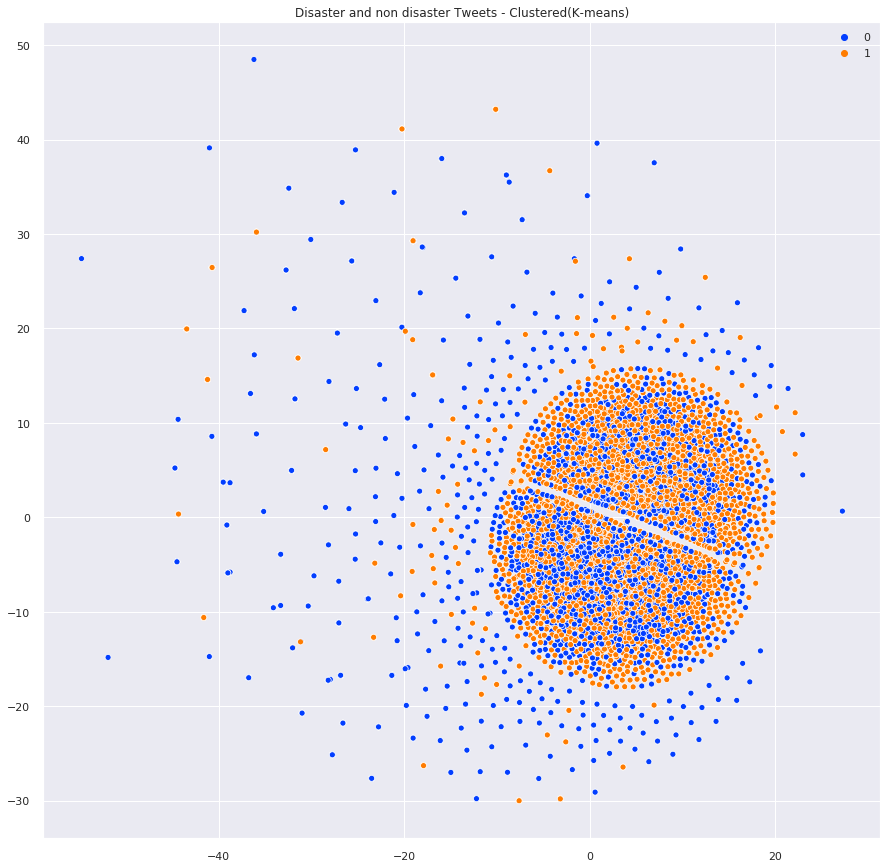

In [33]:
sns.set(rc={'figure.figsize':(15,15)})

palette = sns.color_palette("bright", len(set(y_pred)))

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("Disaster and non disaster Tweets - Clustered(K-means)")
plt.show()

* #### Vectorize with Tf-idf
* #### MiniBatchKMeans with Tf-idf
* #### Dimensionality Reduction with t-SNE

In [34]:
vectorizer = TfidfVectorizer(max_features=2**12)
X = vectorizer.fit_transform(train['text'].values)

In [35]:
X.shape

(7613, 4096)

In [36]:
k = 2
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
y = y_pred

In [37]:
tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7613 samples in 5.022s...
[t-SNE] Computed neighbors for 7613 samples in 487.424s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7613
[t-SNE] Computed conditional probabilities for sample 2000 / 7613
[t-SNE] Computed conditional probabilities for sample 3000 / 7613
[t-SNE] Computed conditional probabilities for sample 4000 / 7613
[t-SNE] Computed conditional probabilities for sample 5000 / 7613
[t-SNE] Computed conditional probabilities for sample 6000 / 7613
[t-SNE] Computed conditional probabilities for sample 7000 / 7613
[t-SNE] Computed conditional probabilities for sample 7613 / 7613
[t-SNE] Mean sigma: 0.479002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 140.383545
[t-SNE] KL divergence after 1000 iterations: 3.943503


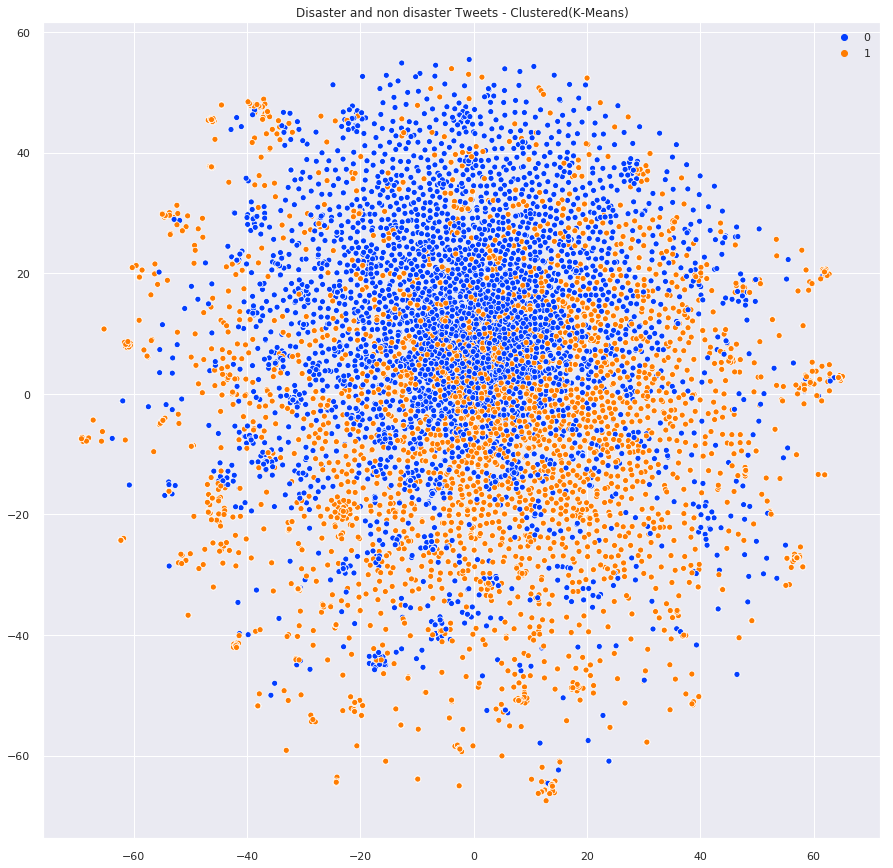

In [38]:
sns.set(rc={'figure.figsize':(15,15)})

palette = sns.color_palette("bright", len(set(y)))

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("Disaster and non disaster Tweets - Clustered(K-Means)")
plt.show()

In [39]:
del train
gc.collect()

7210

In [40]:
temp_3 = train_df
test_temp = test_df

## Fasttext Supervised
-----
### SCORE (0.78936)

In [41]:
temp_3['location'] = temp_3['location'].fillna('no')
temp_3['keyword'] = temp_3['keyword'].fillna('no')
test_temp['location'] = test_temp['location'].fillna('no')
test_temp['keyword'] = test_temp['keyword'].fillna('no')

In [42]:
temp_3['text'] = temp_3["text"].apply(review_to_words) 
test_temp['text'] = test_temp["text"].apply(review_to_words) 
temp_3['location'] = temp_3["location"].apply(review_to_words) 
test_temp['location'] = test_temp["location"].apply(review_to_words) 

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:389: UserWarning:

"http://www.amazon.com/dp/B00HR" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:389: UserWarning:

"http://twitch.tv/jcmonkey" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:389: UserWarning:

"http://wingssilverwork.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:389: UserWarning:

"http://t.co/mOY6lmu" looks like a URL. Beautiful 

In [43]:
def convert_target(x):
    if x == 1:
        x = "disaster"
    else:
        x = "nodisaster"
    return x

In [44]:
temp_3['target'] = temp_3.target.apply(lambda x : convert_target(x))

In [45]:
def xyz(x):
    d = str(x['text']) + " " + str(x['keyword'])+ " " + str(x['location'])    
    c = str(x['target'])
    p = "__label__" + c
    final = p + " " + d
    return final

temp_3 = temp_3.apply(xyz, axis=1)
temp_3_copy = temp_3.copy()

In [46]:
temp_3.to_csv(r'm.txt', header=None, index=None)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.



In [47]:
os.system("head -n 7613 m.txt > m.train")

0

In [48]:
model = fasttext.train_supervised(input="m.train")

In [49]:
def target(x):
    d = str(x['text']) + " " + str(x['keyword'])+ " " + str(x['location'])  
    target = model.predict(d)
    return target[0][0][9]

test_temp['target'] = test_temp.apply(target, axis=1)

In [50]:
def convert_target(x):
    if x == "d":
        x = 1
    else:
        x = 0
    return x

In [51]:
test_temp['target'] = test_temp.target.apply(lambda x : convert_target(x))

In [52]:
test_temp[["id", "target"]].to_csv('submissionfasttext.csv', index=False)

In [53]:
del temp_3, test_temp
gc.collect()

120

## Tf-idf & TruncatedSVD
-----------
### Score (0.80163)

In [54]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [55]:
temp_3 = train_df
test_temp = test_df

> "Term Frequency (tf): gives us the frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases."

> "Inverse Data Frequency (idf): used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score. It is given by the equation below."

In [56]:
temp_3['text'] = temp_3["text"].apply(review_to_words) 
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(temp_3['text'])
test_vectors = vectorizer.transform(test_df["text"])

> "This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition.(...)"

> "In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text.(...)"

In [57]:
tsvd = TruncatedSVD(2000)
train_vectors_svd = tsvd.fit_transform(train_vectors)
test_vectors_svd = tsvd.transform(test_vectors)

In [58]:
clf = linear_model.RidgeClassifier()

In [59]:
scores = model_selection.cross_val_score(clf, train_vectors_svd, train_df["target"], cv=3, scoring="f1")
scores

array([0.60303688, 0.57271815, 0.66300549])

In [60]:
clf.fit(train_vectors_svd, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

### Export

In [61]:
sample_submission["target"] = clf.predict(test_vectors_svd)

In [62]:
sample_submission.to_csv("submission.csv", index=False)

## Shallow neural network

-------------
* Score (0.58793)
* Score (0.68711) init weights
* Score (0.69631) without freezing
* Score (0.72290) without freezing & learning rate 0.5 
* Score (0.66257) without freezing & learning rate 0.3 & 80% training dataset 


![](https://miro.medium.com/max/391/1*CfdaqnNb6RHLzPJTt1UXjQ.png)


In [63]:
%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nlp = spacy.load("en")

In [65]:
def is_token_allowed(token):
    '''
    Only allow valid tokens which are not stop words
    and punctuation symbols.
    '''
    if (not token or not token.string.strip() or
        token.is_stop or token.is_punct):
        return False
    return True

def preprocess_token(token):
    # Reduce token to its lowercase lemma form
    return token.lemma_.strip().lower()

def tokenizer(text):
    return [ preprocess_token(token) for token in nlp.tokenizer(text) if is_token_allowed(token)]

In [66]:
text = data.Field(tokenize=tokenizer, pad_first=True)

train_dataset = data.TabularDataset(
            path="/kaggle/input/nlp-getting-started/train.csv", format='csv',
            fields=[('id', data.Field()),
                    ('keyword', text),
                    ('location', data.Field()),
                    ('text', text),
                    ('target', data.Field())], 
            skip_header=True)

test_dataset = data.TabularDataset(path="/kaggle/input/nlp-getting-started/test.csv", format='csv',
            fields=[('id', data.Field()),
                    ('keyword', text),
                    ('location', data.Field()),
                    ('text', text)], 
            skip_header=True)

In [67]:
MIN_FREQ = 2

text.build_vocab(train_dataset, test_dataset, min_freq=MIN_FREQ)

VOCAB_SIZE = len(text.vocab)

In [68]:
NGRAMS = 2
BATCH_SIZE = 8
EMBED_DIM = 768

class ShallowNeuralNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return F.softmax(self.fc(embedded))

In [69]:
def generate_batch(batch):
    label = torch.tensor([int(entry.target[0]) for entry in batch])
    _text = []
    for entry in batch:
        _entry = []
        for t in entry.text:
            _entry.append(text.vocab.stoi[t])
        _text.append(torch.tensor(_entry,dtype=torch.long))
    offsets = [0] + [len(entry) for entry in _text]
    
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    _text = torch.cat(_text)
    return _text, offsets, label

In [70]:
def train_func(sub_train_):
    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
    
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()
    
    return train_loss / len(sub_train_), train_acc / len(sub_train_)

In [71]:
def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

* Learning rate 0.5
* Training dataset 0.95

In [72]:
model = ShallowNeuralNetwork(VOCAB_SIZE, EMBED_DIM, 2).to(device)

N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch: 1  | time in 0 minutes, 1 seconds
	Loss: 0.0762(train)	|	Acc: 68.4%(train)
	Loss: 0.0028(valid)	|	Acc: 76.1%(valid)
Epoch: 2  | time in 0 minutes, 1 seconds
	Loss: 0.0663(train)	|	Acc: 78.7%(train)
	Loss: 0.0027(valid)	|	Acc: 76.4%(valid)
Epoch: 3  | time in 0 minutes, 1 seconds
	Loss: 0.0637(train)	|	Acc: 81.0%(train)
	Loss: 0.0027(valid)	|	Acc: 76.9%(valid)
Epoch: 4  | time in 0 minutes, 1 seconds
	Loss: 0.0625(train)	|	Acc: 82.4%(train)
	Loss: 0.0027(valid)	|	Acc: 77.7%(valid)
Epoch: 5  | time in 0 minutes, 1 seconds
	Loss: 0.0621(train)	|	Acc: 83.0%(train)
	Loss: 0.0027(valid)	|	Acc: 77.2%(valid)


In [73]:
def predict(_text, model, vocab, ngrams):
    if len(_text) == 0:
        return 0
    
    with torch.no_grad():
        _text = [vocab.stoi[token] for token in ngrams_iterator(_text, ngrams)]
        output = model(torch.tensor(_text), torch.tensor([0]))
        return output.argmax(1).item()

In [74]:
model = model.to("cpu")
predictions = [predict(entry.text, model, text.vocab, NGRAMS) for entry in test_dataset]
tweet_id = [entry.id[0] for entry in test_dataset]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



### Export

In [75]:
output = pd.DataFrame({'id': tweet_id, 'target': predictions})
output.to_csv('my_submission.csv', index=False)